#### SIADS 696 Milestone II

In [9]:
import pandas as pd
import numpy as np
from data_columns import childhood, demographic, diagnosis, all
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import umap.umap_ as umap
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import hdbscan
import warnings
warnings.filterwarnings("ignore")


In [10]:
init_df = pd.read_csv('./data/mental-health-comorbidity-raw.csv')
init_df.shape

(5001, 1000)

In [11]:
df = init_df[all()].copy()
df = df.replace(-9, np.nan)
df = df.dropna()
df.shape

(4959, 122)

In [12]:
columns2 = demographic() + childhood() + ['DSM_DRA']
num_columns = ["HHSIZE","AGE"] + ["CH13","CH14","CH16","CH21","CH22","CH24","CH38","CH43","CH45"]
child_df = df[columns2].copy()

child_df = child_df.replace(-9, np.nan)
child_df = child_df.dropna()

cat_columns = [col for col in child_df.columns if col not in num_columns]
child_df[cat_columns] = child_df[cat_columns].astype('category')
child_df[num_columns] = child_df[num_columns].astype(int)


In [13]:
cat_columns1 = [col for col in cat_columns if col != 'DSM_DRA']

X = child_df.drop(columns=['DSM_DRA'])
y = child_df['DSM_DRA']

preprocessor2 = ColumnTransformer([
    ("num", StandardScaler(), num_columns),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_columns1)
])

pipeline2 = Pipeline(steps=[
    ("preprocessor", preprocessor2),
    # ("sampler", RandomOverSampler(random_state=42)),
    ("sampler", RandomUnderSampler(random_state=42)),
    ("classifier", RandomForestClassifier(random_state=42))
    # ("classifier", LogisticRegression(max_iter=500))
    # ("classifier", GaussianNB())
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline2, X, y, cv=cv, scoring="f1_weighted") #f1_macro , precision_macro, recall_macro, f1_weighted
print("Cross-val scores:", scores)
print("Mean score:", scores.mean())

Cross-val scores: [0.73823979 0.708971   0.72741677 0.73458971 0.72784011]
Mean score: 0.7274114785813094


In [14]:
X_cluster = X.copy()

preprocessor3 = ColumnTransformer([
    ("num", StandardScaler(), num_columns),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_columns1)
])

X_preprocessed1 = preprocessor3.fit_transform(X_cluster)

In [15]:
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X_preprocessed1)

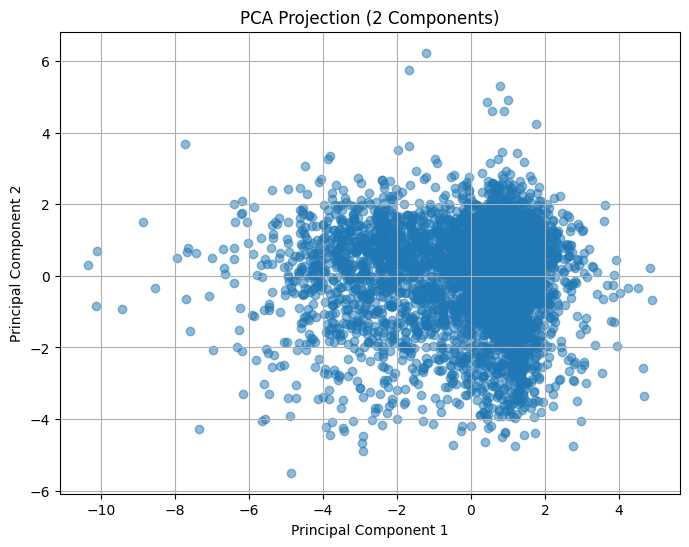

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title("PCA Projection (2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

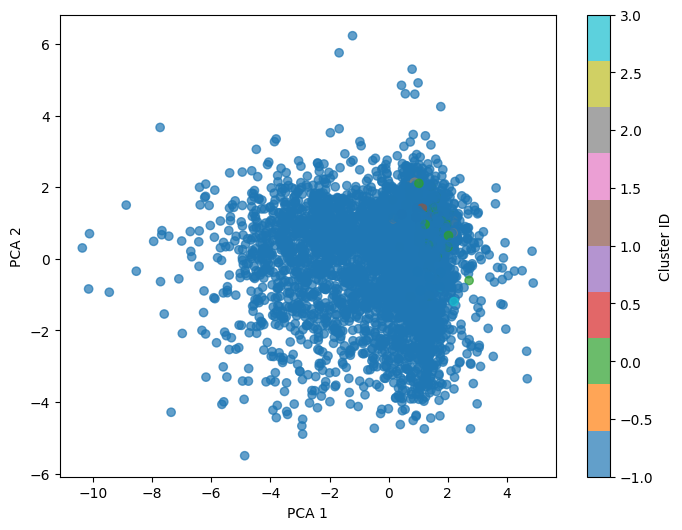

In [17]:
dbscan = DBSCAN(eps=4.0, min_samples=10)
labels = dbscan.fit_predict(X_preprocessed1)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10", alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster ID")
plt.show()

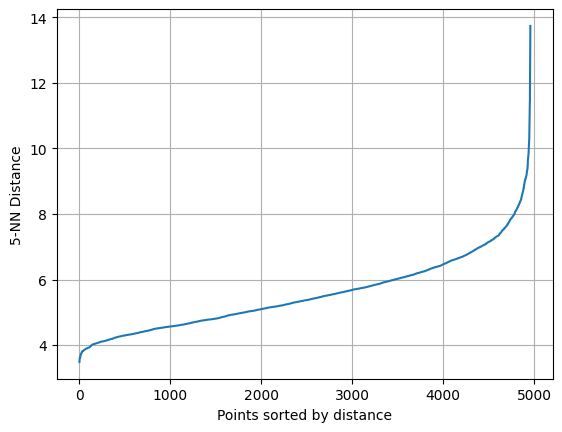

In [18]:
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(X_preprocessed1)
distances, indices = neighbors_fit.kneighbors(X_preprocessed1)

k_distances = np.sort(distances[:, 4])
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("5-NN Distance")
plt.grid(True)
plt.show()

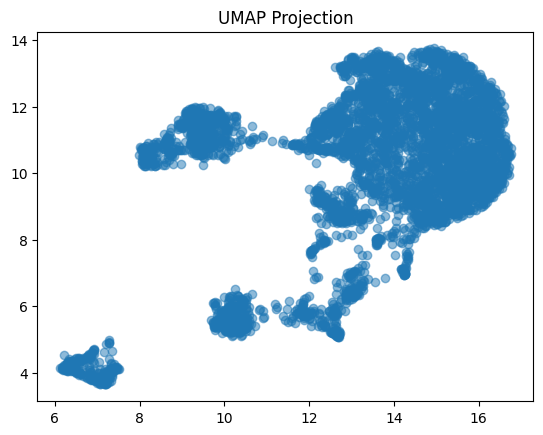

In [19]:
umap_model = umap.UMAP(random_state=42)
X_umap = umap_model.fit_transform(X_preprocessed1)

plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.5)
plt.title("UMAP Projection")
plt.show()

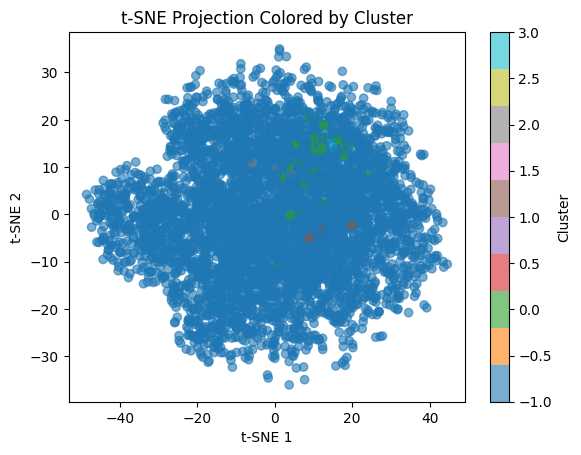

In [20]:
X_tsne = TSNE(n_components=3, random_state=42, perplexity=30).fit_transform(X_preprocessed1)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap="tab10", alpha=0.6)
plt.title("t-SNE Projection Colored by Cluster")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label="Cluster")
plt.show()

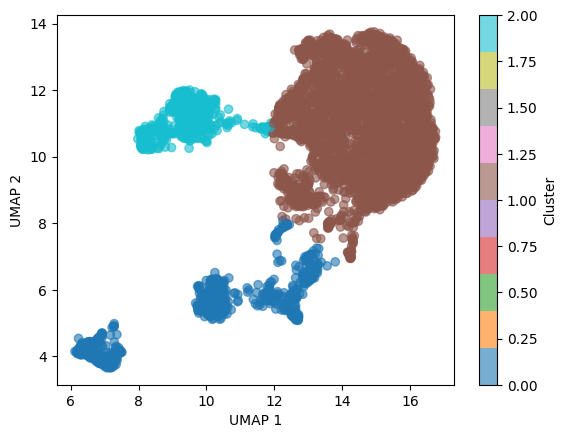

In [21]:
kmeans1 = KMeans(n_clusters=3, random_state=42)
labels1 = kmeans1.fit_predict(X_umap)

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels1, cmap='tab10', alpha=0.6)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster")
plt.show()

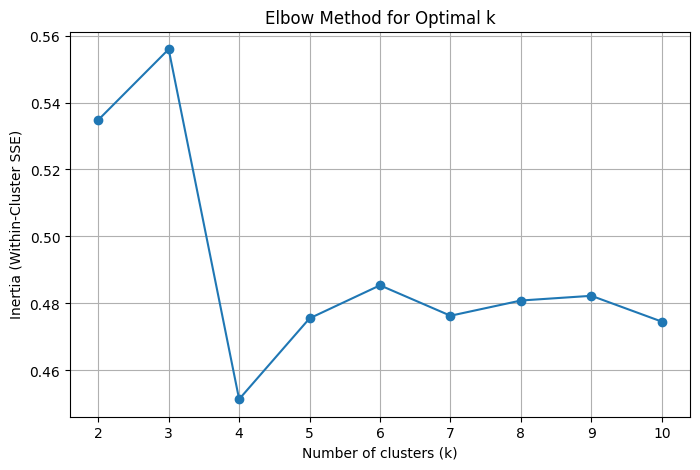

In [22]:
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_umap)
    score = silhouette_score(X_umap, labels)
    sil_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

In [23]:
X_clustered = X.copy()
X_clustered["cluster"] = labels1
X_clustered.cluster.value_counts()

cluster
1    3493
0     856
2     610
Name: count, dtype: int64

In [24]:
X_clustered.groupby("cluster")[num_columns].describe()['AGE']

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,856.0,41.031542,10.664482,25.0,32.0,39.0,49.0,66.0
1,3493.0,42.845691,10.341780,25.0,34.0,42.0,51.0,69.0
2,610.0,46.916393,10.029573,25.0,40.0,47.0,55.0,67.0


In [25]:
X_clustered.groupby("cluster")['EDUCAT'].value_counts().unstack()

EDUCAT,1.0,2.0,3.0,4.0
cluster,,,,
0,134,276,276,170
1,294,950,1030,1219
2,95,188,172,155


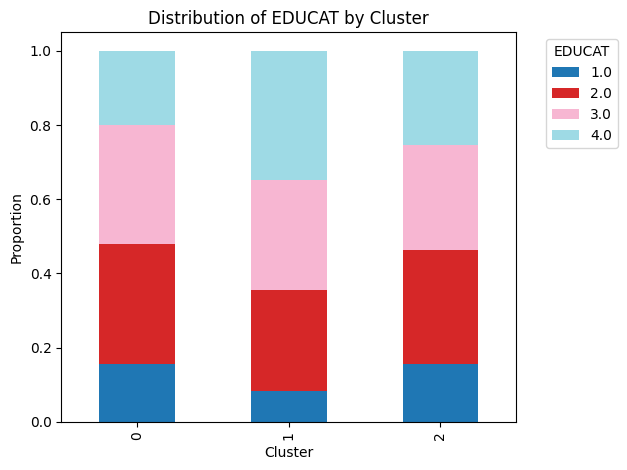

In [37]:
feature = 'EDUCAT'
crosstab = pd.crosstab(X_clustered['cluster'], X_clustered[feature], normalize='index')

crosstab.plot(kind='bar', stacked=True, colormap='tab20')
plt.title(f"Distribution of {feature} by Cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [26]:
dbscan = DBSCAN(eps=.7, min_samples=50)
# dbscan = hdbscan.HDBSCAN(min_cluster_size=7)
labels2 = dbscan.fit_predict(X_umap)

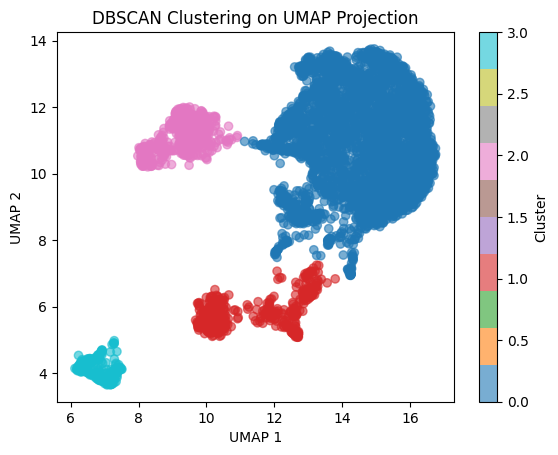

In [27]:
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels2, cmap="tab10", alpha=0.6)
plt.title("DBSCAN Clustering on UMAP Projection")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster")
plt.show()

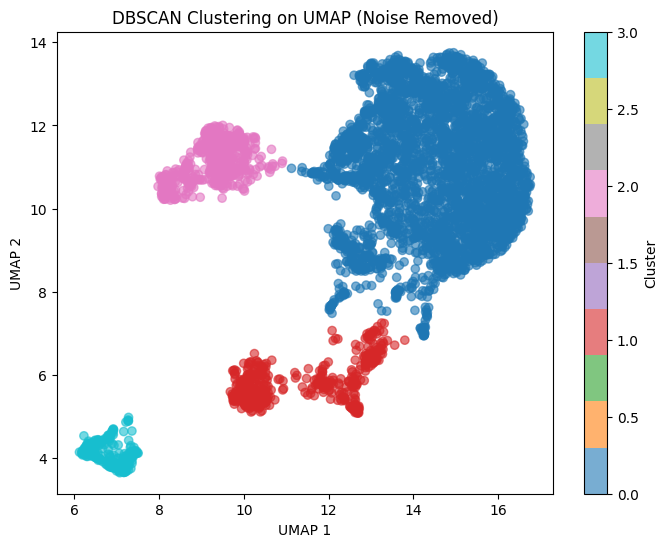

In [28]:
non_noise_mask = labels2 != -1

X_clean = X_umap[non_noise_mask]
labels_clean = labels2[non_noise_mask]

# Plot without noise
plt.figure(figsize=(8, 6))
plt.scatter(X_clean[:, 0], X_clean[:, 1], c=labels_clean, cmap="tab10", alpha=0.6)
plt.title("DBSCAN Clustering on UMAP (Noise Removed)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster")
plt.show()


In [38]:
all_df = df[all()].copy()

all_df = all_df.replace(-9, np.nan)
all_df = all_df.dropna()

num_columns2 = ["HHSIZE","AGE"] + ["CH13","CH14","CH16","CH21","CH22","CH24","CH38","CH43","CH45"]
cat_columns4 = [col for col in all_df.columns if col not in num_columns2]
all_df[cat_columns4] = all_df[cat_columns4].astype('category')
all_df[num_columns] = all_df[num_columns2].astype(int)


X_cluster2 = all_df

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_columns2),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_columns4)
])

X_preprocessed2 = preprocessor.fit_transform(X_cluster2)

In [39]:
umap_model = umap.UMAP(random_state=42)
X_umap2 = umap_model.fit_transform(X_preprocessed2)

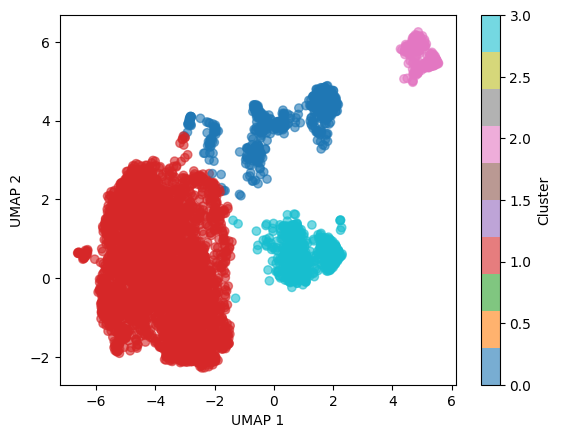

In [40]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels4 = kmeans.fit_predict(X_umap2)

plt.scatter(X_umap2[:, 0], X_umap2[:, 1], c=labels4, cmap='tab10', alpha=0.6)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster")
plt.show()

In [41]:
X_clustered2 = all_df.copy()
X_clustered["cluster"] = labels4
X_clustered.cluster.value_counts()

cluster
1    3497
0     612
3     590
2     260
Name: count, dtype: int64

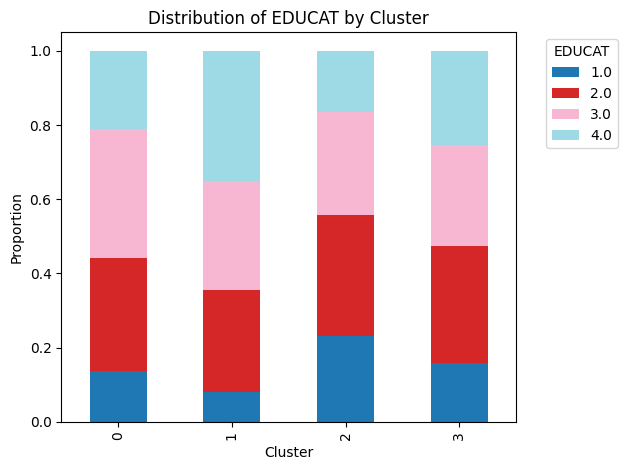

In [42]:
feature = 'EDUCAT'
crosstab = pd.crosstab(X_clustered['cluster'], X_clustered[feature], normalize='index')

crosstab.plot(kind='bar', stacked=True, colormap='tab20')
plt.title(f"Distribution of {feature} by Cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

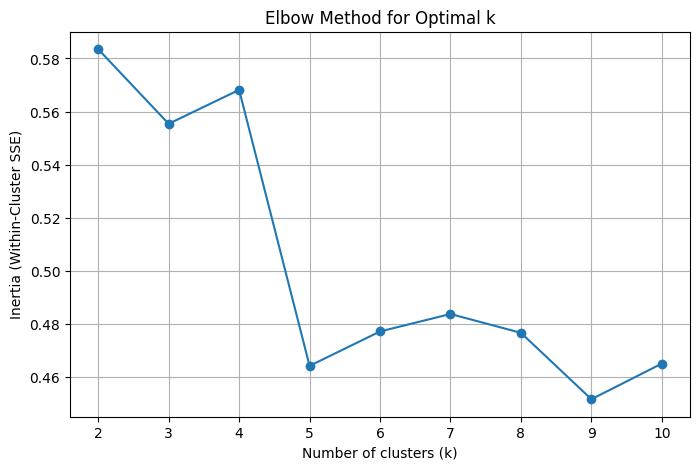

In [32]:
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_umap2)
    score = silhouette_score(X_umap2, labels)
    sil_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

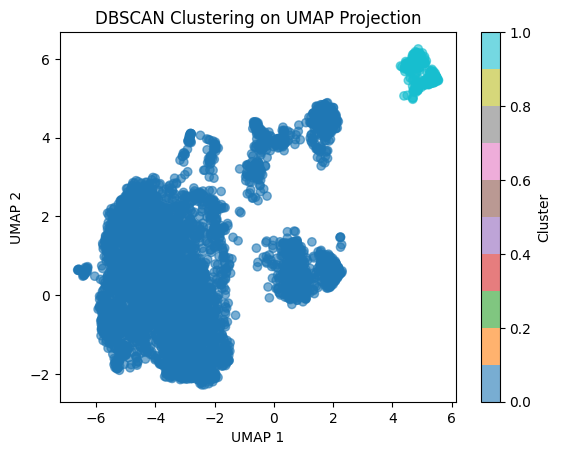

In [33]:
dbscan2 = DBSCAN(eps=.7, min_samples=4)
labels5 = dbscan2.fit_predict(X_umap2)

plt.scatter(X_umap2[:, 0], X_umap2[:, 1], c=labels5, cmap="tab10", alpha=0.6)
plt.title("DBSCAN Clustering on UMAP Projection")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster")
plt.show()